# Setup

## Imports

In [1]:
import os.path
import cupy as cp
import tensorflow as tf

from tqdm import tqdm_notebook
from skimage.color import rgb2lab
from skimage.transform import resize
from glob import glob

/home/vaisakh/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


vai Modules

In [2]:
from vaiutils import path_consts, randpick, smooth_plot
from vaidata import pickle_dump, pickle_load

Keras Modules

In [3]:
import keras.backend as K

from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, Conv2DTranspose, Input, BatchNormalization, UpSampling2D
from keras.optimizers import Adam
from keras.engine.topology import Layer
from keras_tqdm import TQDMNotebookCallback

Using TensorFlow backend.


## Define Useful Features

In [4]:
for k, v in path_consts('COCO'):
    exec(k + ' = v')

## Checks

In [5]:
assert os.path.exists(os.path.join(DIR_CHECKPOINTS, 'ab_bins.npy')), "Gamut Bins not found.\nRun GamutBins Notebook first"

In [6]:
assert os.path.exists(os.path.join(DIR_CHECKPOINTS, 'class_weights.npy')), "Class Weights not found.\nRun ClassRebalancer Notebook first"

In [7]:
assert os.path.exists(os.path.join(DIR_CHECKPOINTS, 'probabilities.npy')), "Point probabilities not found.\nRun Fastener Notebook first or stick with (Slow) Trainer"

In [8]:
assert os.path.exists(os.path.join(DIR_DATA, 'lab')), "LAB images not found.\nRun Fastener Notebook first or stick with (Slow) Trainer"

## Load Data

In [9]:
ab_bins = np.load(os.path.join(DIR_CHECKPOINTS, 'ab_bins.npy'))
Q = len(ab_bins)

In [10]:
class_weights = K.constant(np.load(os.path.join(DIR_CHECKPOINTS, 'class_weights.npy')))

In [11]:
probabilities = K.constant(np.load(os.path.join(DIR_CHECKPOINTS, 'probabilities.npy')))

In [12]:
filenames = sorted(glob(os.path.join(DIR_DATA, 'lab', '*.npy')))

***
**WARNING!**

If the Kernel dies after running the following cell or for any reason therafter, probably the next cell is the culprit.

It tries to load the entire data (in LAB format) as one giant array.
Maybe your RAM has run out of memory.

In that case, just don't run this cell.
Delete or comment it out.

The notebook will take care of it.

In [13]:
if os.path.exists(os.path.join(DIR_DATA, 'lab.npz')):
    lab_data = np.load(os.path.join(DIR_DATA, 'lab.npz'))['lab']
else:
    lab_data = np.zeros((len(filenames), 224, 224, 2), dtype=uint16)
    for i, filename in enumerate(tqdm_notebook(filenames)):
        lab_data[i] = np.load(filename)
    np.savez_compressed(os.path.join(DIR_DATA, 'lab.npz'), lab=lab_data)

***

In [14]:
using_full_data = 'lab_data' in globals()

In [15]:
batch_size = 4

In [16]:
def lab_generator():
    while True:
        select_idx = randint(0, len(filenames), batch_size)
        if using_full_data:
            lab = np.take(lab_data, select_idx, 0)
        else:
            lab = np.zeros((batch_size, 224, 224, 2), dtype=uint16)
            for i, filename in enumerate(filenames[select_idx]):
                lab[i] = np.load(filename)
        
        l, ab_idx = np.take(lab, [0], -1).astype(float32) - 50, np.take(lab, 1, -1)
           
        yield([l, ab_idx], np.zeros((batch_size, 1)))

# Define Model

In [17]:
def conv_layer(x, filters, strides=1, idx=1, dilations=1):
    if type(dilations) is int:
        dilations = [dilations]*len(strides)
    elif type(strides) is int:
        strides = [strides]*len(dilations)
    
        
    for i, (stride, dilation) in enumerate(zip(strides, dilations)):
        if type(stride) is int:
            x = Conv2D(filters, 3, strides=stride, padding='same', dilation_rate=dilation,
                       activation='relu', name='conv' + str(idx) + '_' + str(i+1))(x)
        else:
            x = Conv2DTranspose(filters, 3, strides=int(1 / stride), padding='same',
                                activation='relu', name='conv' + str(idx) + '_' + str(i+1))(x)
    return BatchNormalization(name='bn' + str(idx))(x)

In [18]:
def get_model():
    l_in = Input((224, 224, 1))
    
    x = conv_layer(l_in, 64, [1, 2], 1)
    x = conv_layer(x, 128, [1, 2], 2)
    x = conv_layer(x, 256, [1, 1, 2], 3)
    x = conv_layer(x, 512, [1]*3, 4)
    x = conv_layer(x, 512, [1]*3, 5, 2)
    x = conv_layer(x, 512, [1]*3, 6, 2)
    x = conv_layer(x, 256, [1]*3, 7)
    x = conv_layer(x, 128, [0.5, 1, 1], 8)
    x = Conv2D(Q, 1, padding='same', name='conv9')(x)
    x = UpSampling2D(4, name='upsample')(x)
    
    model = Model(l_in, x)
    return model

In [19]:
model_name = 'model'

In [20]:
os.makedirs(os.path.join(DIR_CHECKPOINTS, '.last'), exist_ok=True)

In [21]:
if os.path.exists(os.path.join(DIR_CHECKPOINTS, model_name + '.h5')):
    model = load_model(os.path.join(DIR_CHECKPOINTS, model_name + '.h5'))
else:
    model = get_model()

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 1)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      640       
_________________________________________________________________
conv1_2 (Conv2D)             (None, 112, 112, 64)      36928     
_________________________________________________________________
bn1 (BatchNormalization)     (None, 112, 112, 64)      256       
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 56, 56, 128)       147584    
_________________________________________________________________
bn2 (BatchNormalization)     (None, 56, 56, 128)       512       
__________

In [22]:
class Probablize(Layer):
    def call(self, ab_idx):
        return K.gather(probabilities, ab_idx)
    
    def compute_output_shape(self, input_shape):
        prob_shape = list(input_shape)
        prob_shape.append(Q)
        return tuple(prob_shape)

In [23]:
class CrossEntropy(Layer):
    def call(self, x):
        ab_true, ab_pred = x
        max_idx = K.argmax(ab_true)
        pixel_weights = K.expand_dims(K.gather(class_weights, max_idx))
        batch_size = K.shape(ab_true)[0]
        
        return K.reshape(K.categorical_crossentropy(ab_true * pixel_weights, ab_pred, True), (batch_size, -1))
    
    def compute_output_shape(self, input_shape):
        return (None, 1)

In [24]:
def identity_error(dummy_target, loss):
    return K.mean(loss, axis=-1)

In [25]:
l = Input((224, 224, 1), name='l')
ab_idx = Input((224, 224), dtype=int32, name='ab_idx')

ab_true = Probablize(name='probablize')(ab_idx)
ab_pred = model(l)

loss = CrossEntropy(name='cross_entropy')([ab_true, ab_pred])

trainer = Model([l, ab_idx], loss)
trainer.compile(Adam(3e-5, beta_2=0.99, decay=1e-3), identity_error)
trainer.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ab_idx (InputLayer)             (None, 224, 224)     0                                            
__________________________________________________________________________________________________
l (InputLayer)                  (None, 224, 224, 1)  0                                            
__________________________________________________________________________________________________
probablize (Probablize)         (None, 224, 224, 245 0           ab_idx[0][0]                     
__________________________________________________________________________________________________
model_1 (Model)                 (None, 224, 224, 245 24784309    l[0][0]                          
__________________________________________________________________________________________________
cross_entr

In [26]:
history = pickle_load(os.path.join(DIR_CHECKPOINTS, model_name + '-history.p'), {'loss': []})

In [27]:
batches_per_epoch = int(len(filenames) / batch_size)

In [28]:
def train(epochs=1):
    model.save(os.path.join(DIR_CHECKPOINTS, '.last', model_name + '.h5'))
    pickle_dump(os.path.join(DIR_CHECKPOINTS, '.last', model_name + '-history.p'), history)
    
    for epoch in tqdm_notebook(range(epochs)):
        hist = trainer.fit_generator(lab_generator(), batches_per_epoch,
                            verbose=0, callbacks=[TQDMNotebookCallback(show_outer=False)])

        history['loss'] += hist.history['loss']

        pickle_dump(os.path.join(DIR_CHECKPOINTS, model_name + '-history.p'), history)

        model.save(os.path.join(DIR_CHECKPOINTS, model_name + '.h5'))

In [29]:
train(5)

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=1215), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=1215), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=1215), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=1215), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=1215), HTML(value='')))

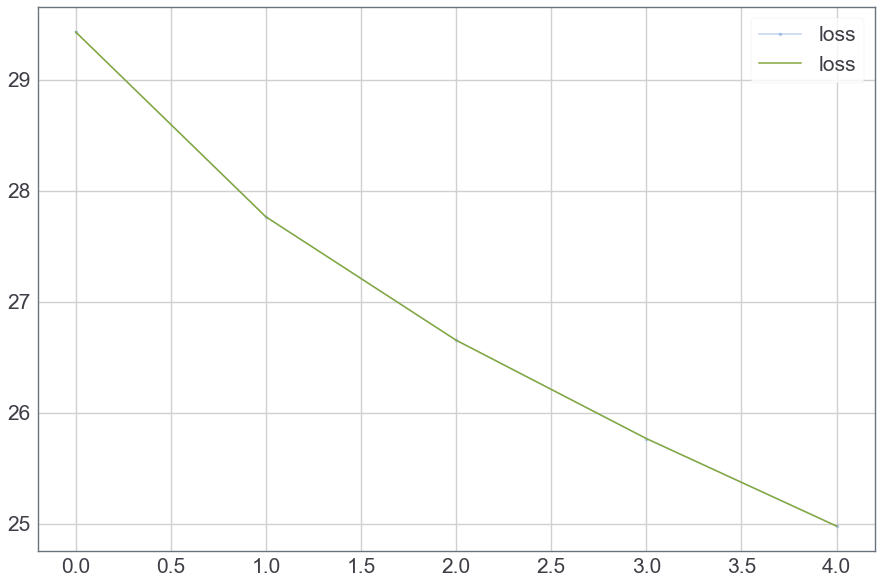

In [30]:
smooth_plot(history)